In [2]:
import json
import gseapy as gp
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import joblib

from tqdm import tqdm

from get_gene_col import ALL_GENE_NAMES

sns.set_style("white")

CELLTYPES = [
    "Astrocyte",
    "Microglia-PVM",
    "Oligodendrocyte",
    "Glutamatergic",
    "GABAergic",
]

WATCH_LIST = [" ad ", "alz", "cogni", "calci", "dementia", "memory", "parkinson", "ptau", "plaque"]

In [3]:
all_libraries = gp.get_library_name()
selected_libraries = [
    'DisGeNET',
    'GWAS_Catalog_2023',
    'HDSigDB_Human_2021',
]

In [4]:
ct_enr = dict()
comb_top_genes = []
for celltype in tqdm(CELLTYPES, desc="GSEA per celltype"):
    score = pd.read_csv(f"../../out/results/attention_correlation_{celltype}_th80.csv")
    
    ct_top_genes = score.head(20)["gene"].to_list()
    comb_top_genes.extend(ct_top_genes)

    ct_enr[celltype] = gp.enrich(
        gene_list=list(set(ct_top_genes)), 
        gene_sets=selected_libraries,
        background=ALL_GENE_NAMES,
    ) \
    .results \
    .drop(["Old P-value", "Old adjusted P-value"], axis=1)

print("Running GSEA for combined celltypes")
ct_enr["Combined"] = gp.enrich(
    gene_list=list(set(comb_top_genes)), 
    gene_sets=selected_libraries,
    background=ALL_GENE_NAMES,
).results.drop(["Old P-value", "Old adjusted P-value"], axis=1)

print("All results returned")

# Here we combine the results into a single dataframe per celltype
df = []
for celltype in [*CELLTYPES, "Combined"]:
    res = ct_enr[celltype]
    
    res_sig = res[res["Adjusted P-value"] < 0.05].copy()
    res_sig["logOR"] = res_sig["Odds Ratio"].apply(lambda x: np.log(x))
        
    res_sig.sort_values("logOR", inplace=True, ascending=False)
    res_sig["Celltype"] = celltype
    df.append(res_sig)

df = pd.concat(df)
df.to_csv("../../out/results/gsea_results.csv", index=False)

GSEA per celltype: 100%|██████████| 5/5 [00:46<00:00,  9.22s/it]


Running GSEA for df celltypes
All results returned


In [26]:
# Or we can load an existing dataframe instead
df = pd.read_csv("../../out/results/gsea_results.csv")

ad_terms = [term for term in df["Term"] \
    if any(w in term.lower() for w in WATCH_LIST)]

print(f"Total remaining terms: {len(df)}, of which AD terms: {len(ad_terms)}")

Total remaining terms: 5482, of which AD terms: 182


In [23]:
with open("../../data/term_name_map.json", mode="r") as f:
    term_aliases = json.load(f)

C:\Users\timov\AppData\Local\Temp\ipykernel_7516\1912252270.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(df_top["Term"].unique(), fontsize=14)
C:\Users\timov\AppData\Local\Temp\ipykernel_7516\1912252270.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(df_ad["Term"].unique(), fontsize=14)


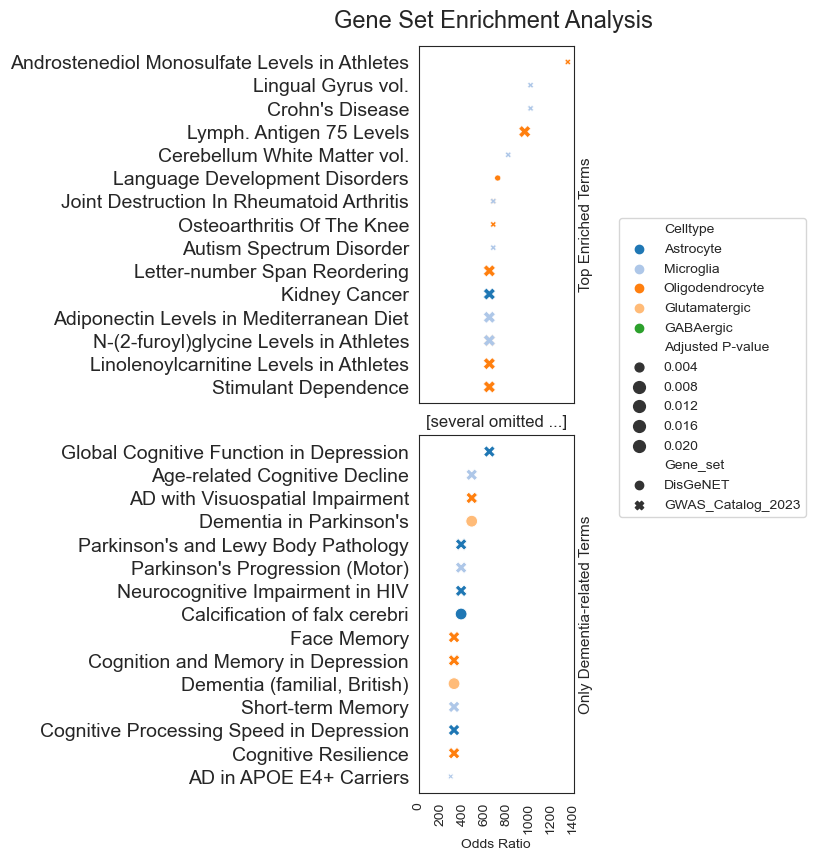

In [29]:
N_TOP_TERMS = 17
N_AD_TERMS = 22
MARKER_SIZE_NORM = (0.0015, 0.0075)

df = df[np.array(
    ["vag" not in term.lower() for term in df["Term"]]
)]

# Rename the Microglia
df["Celltype"] = np.select(
    condlist=[df["Celltype"] == "Microglia-PVM"],
    choicelist=["Microglia"],
    default=df["Celltype"],
)

df = df[df["Celltype"] != "Combined"]
df = df[df["Gene_set"] != "HDSigDB_Human_2021"].copy()

df.sort_values("Odds Ratio", inplace=True, ascending=False)

# For the first half of the plot
df_top = df.copy()
df_top["Term"] = np.select(
    condlist=[df_top["Term"].isin(term_aliases.keys())],
    choicelist=[df_top["Term"].map(term_aliases)],
    default=df_top["Term"],
)
df_top = df_top.head(N_TOP_TERMS).copy()


# For the second half of the plot
df_ad = df.copy()
df_ad = df_ad[df_ad["Term"].isin(ad_terms)].copy()
df_ad["Term"] = np.select(
    condlist=[df_ad["Term"].isin(term_aliases.keys())],
    choicelist=[df_ad["Term"].map(term_aliases)],
    default=df_ad["Term"],
)
df_ad = df_ad.head(N_AD_TERMS).copy()


# Setup order
style_order = sorted(list(set([*df_top["Gene_set"].unique(), *df_ad["Gene_set"].unique()])))
hue_order = CELLTYPES.copy()
hue_order[hue_order.index("Microglia-PVM")] = "Microglia"

fig, (ax, ax2) = plt.subplots(
    nrows=2, 
    figsize=(2, (len(df_top) + len(df_ad)) // 4),
    sharex="col",
    gridspec_kw={"height_ratios": [len(df_top["Term"].unique()), len(df_ad["Term"].unique())]},
)

g = sns.scatterplot(
    data=df_top,
    ax=ax,
    x="Odds Ratio",
    y="Term",
    size="Adjusted P-value",
    size_norm=MARKER_SIZE_NORM,
    style="Gene_set",
    style_order=style_order,
    palette="tab20",
    hue="Celltype",
    hue_order=hue_order,
)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.1))
ax.set_yticklabels(df_top["Term"].unique(), fontsize=14)

g = sns.scatterplot(
    data=df_ad,
    ax=ax2,
    x="Odds Ratio",
    y="Term",
    size="Adjusted P-value",
    size_norm=MARKER_SIZE_NORM,
    style="Gene_set",
    style_order=style_order,
    palette="tab20",
    hue="Celltype",
    hue_order=hue_order,
)
ax2.get_legend().remove()
ax2.set_yticklabels(df_ad["Term"].unique(), fontsize=14)

# Put y label on the other side
ax.set_ylabel("Top Enriched Terms", fontsize=11)
ax.yaxis.set_label_position("right")
ax2.set_ylabel("Only Dementia-related Terms", fontsize=11)
ax2.yaxis.set_label_position("right")
ax2.set_title("[several omitted ...]")
ax2.set_xticks(
    np.arange(0, df["Odds Ratio"].max() + 100, 200), 
    np.arange(0, int(df["Odds Ratio"].max()) + 100, 200), 
    rotation=90,
)
ax2.set_xlabel("Odds Ratio")

plt.suptitle("Gene Set Enrichment Analysis", fontsize=17)

plt.subplots_adjust(hspace=0.09, top=0.94)

plt.savefig("../../out/figures/fig_enrichment.png", bbox_inches="tight", dpi=300, transparent=True, facecolor="w")
plt.show()

In [21]:
# This is used to rename the terms in the figure to something more readable
term_name_map = {}
for term in [*df_top["Term"].unique(), *df_ad["Term"].unique()]:
    if term in term_aliases.values():
        old_term = [k for k, v in term_aliases.items() if v == term][0]
        term_name_map[old_term] = term
    else:
        term_name_map[term] = term
        
for term, alias in term_aliases.items():
    if term not in term_name_map.keys():
        term_name_map[term] = alias
        
with open("../../data/term_name_map.json", mode="w") as f:
    json.dump(term_name_map, f, indent=4)
